<a href="https://colab.research.google.com/github/wjw12/Draw_AI_applications/blob/main/handwriting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
root_dir = "drive/My Drive/draw_ai_applications/"
scripts_dir = root_dir + "scripts"
%cd {scripts_dir}

Mounted at /content/drive/
/content/drive/My Drive/draw_ai_applications/scripts


# Before starting
1. Use a colab with GPU runtime
2. Mount root directory in Google Drive

## Data preparation
1. Download on-line handwriting IAM data from https://fki.tic.heia-fr.ch/databases/iam-on-line-handwriting-database (data is large, not included in the repo) and process IAM data to numpy format

2. Load numpy dataset from disk. Each data sample consists of 300 time steps

3. Create simulated dysgraphia data. Use FFT, add gaussian noises in frequency domain, and then inverse FFT. 

4. Build training and validation dataset


In [2]:
import os
import pickle
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

## Data preprocessing
The following code preprocesses raw IAM data to numpy arrays

This will take a long time, only need to be executed once

Data is saved in "handwriting.p" file and can be loaded next time

Each writing sample is a (300, 3) array. Length = 300, dimension = 3 (dx, dy, pen_state)

Pen_state 1 is end of stroke, 0 is moving

In [3]:
def preprocess(stroke_dir, ascii_dir, data_file):
  # create data file from raw xml files from iam handwriting source.
  
  # build the list of xml files
  filelist = []
  # Set the directory you want to start from
  rootDir = stroke_dir
  for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
      filelist.append(dirName+"/"+fname)

  # build stroke database of every xml file inside iam database
  strokes = []
  asciis = []
  for i in range(len(filelist)):
  #for i in range(20):
    try:
      if (filelist[i][-3:] == 'xml'):
        stroke_file = filelist[i]
        stroke = convert_stroke_to_array(getStrokes(stroke_file))
        
        ascii_file = stroke_file.replace("lineStrokes","ascii")[:-7] + ".txt"
        line_number = stroke_file[-6:-4]
        line_number = int(line_number) - 1
        ascii = getAscii(ascii_file, line_number)
        if len(ascii) > 10:
          strokes.append(stroke)
          asciis.append(ascii)
        else:
          print("======>>>> Line length was too short. Line was: " + ascii)
    except:
      print("an error occurred on ", filelist[i])
          
  assert(len(strokes)==len(asciis)), "There should be a 1:1 correspondence between stroke data and ascii labels."
  f = open(data_file,"wb")
  pickle.dump([strokes,asciis], f, protocol=2)
  f.close()
  print("Finished parsing dataset. Saved {} lines".format(len(strokes)))

# function to read each individual xml file
def getStrokes(filename):
  tree = ET.parse(filename)
  root = tree.getroot()

  result = []

  x_offset = 1e20
  y_offset = 1e20
  y_height = 0
  for i in range(1, 4):
    x_offset = min(x_offset, float(root[0][i].attrib['x']))
    y_offset = min(y_offset, float(root[0][i].attrib['y']))
    y_height = max(y_height, float(root[0][i].attrib['y']))
  y_height -= y_offset
  x_offset -= 100
  y_offset -= 100

  for stroke in root[1].findall('Stroke'):
    points = []
    for point in stroke.findall('Point'):
      points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
    result.append(points)
  return result

# function to read each individual xml file
def getAscii(filename, line_number):
  with open(filename, "r") as f:
    s = f.read()
  s = s[s.find("CSR"):]
  if len(s.split("\n")) > line_number+2:
    s = s.split("\n")[line_number+2]
    return s
  else:
    return ""
        
# converts a list of arrays into a 2d numpy int16 array
def convert_stroke_to_array(stroke):
  n_point = 0
  for i in range(len(stroke)):
      n_point += len(stroke[i])
  stroke_data = np.zeros((n_point, 3), dtype=np.int16)

  prev_x = 0
  prev_y = 0
  counter = 0

  for j in range(len(stroke)):
    for k in range(len(stroke[j])):
      stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
      stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
      prev_x = int(stroke[j][k][0])
      prev_y = int(stroke[j][k][1])
      stroke_data[counter, 2] = 0
      if (k == (len(stroke[j])-1)): # end of stroke
        stroke_data[counter, 2] = 1
      counter += 1
  return stroke_data


def load_preprocessed(data_file):
  f = open(data_file,"rb")
  [raw_stroke_data, raw_ascii_data] = pickle.load(f)
  f.close()

  # goes thru the list, and only keeps the text entries that have more than tsteps points
  stroke_data = []
  ascii_data = []
  counter = 0

  limit = 500
  scale_factor = 10  # fixed factor to multiply with dx, dy
  tsteps = 300

  for i in range(len(raw_stroke_data)):
    data = raw_stroke_data[i]
    if len(data) > (tsteps+2):
      # removes large gaps from the data
      data = np.minimum(data, limit)
      data = np.maximum(data, -limit)
      data = np.array(data,dtype=np.float32)
      data[:,0:2] /= scale_factor
      
      stroke_data.append(data)
      ascii_data.append(raw_ascii_data[i])

  return stroke_data, ascii_data
  # minus 1, since we want the ydata to be a shifted version of x data
  # self.num_batches = int(len(self.stroke_data) / self.batch_size)


In [ ]:
# preprocess data
# very slow
# only needs to run once

base_data_dir = "../IAM_data/"
preprocess(base_data_dir + "lineStrokes", base_data_dir + "ascii", "handwriting.p")

In [4]:
# plot writing strokes
def line_plot(strokes, inv=False):
  plt.figure(figsize=(20,2))
  eos_preds = np.where(strokes[:,-1] == 1)
  eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
  for i in range(len(eos_preds)-1):
    start = eos_preds[i]+1
    stop = eos_preds[i+1]
    plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0)
  if inv:
    plt.gca().invert_yaxis()
  plt.show()

# visualize a batch of data


11600
(300, 3)


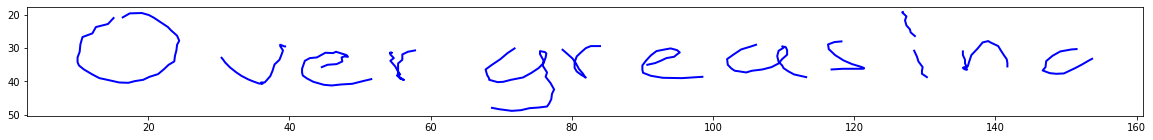

(300, 3)


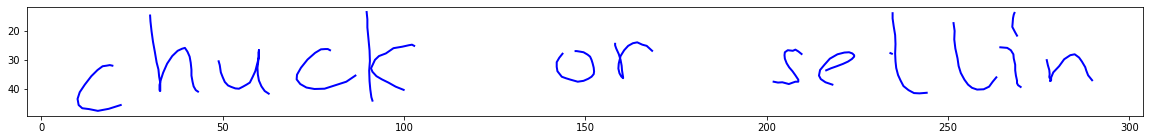

(300, 3)


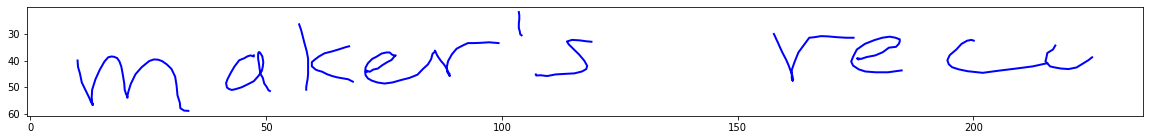

(300, 3)


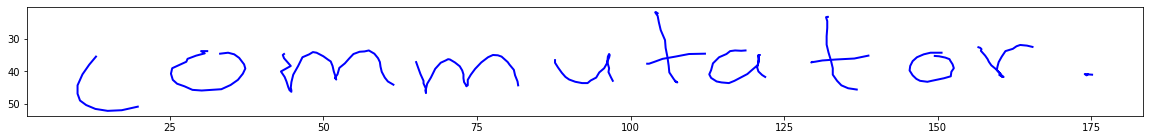

(300, 3)


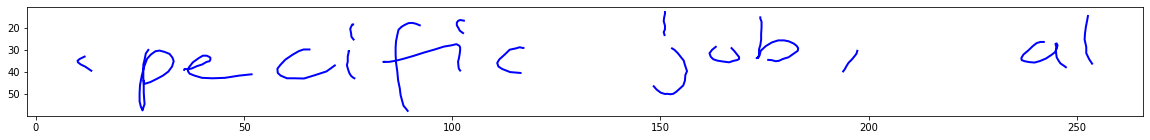

In [6]:
strokes, ascii = load_preprocessed("handwriting.p")
def line_plot(strokes):
  plt.figure(figsize=(20,2))
  eos_preds = np.where(strokes[:,-1] == 1)
  eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
  for i in range(len(eos_preds)-1):
    start = eos_preds[i]+1
    stop = eos_preds[i+1]
    plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0)
  plt.gca().invert_yaxis()
  plt.show()

print(len(strokes))
# x,y,s,c
x_batch = []
y_batch = []
ascii_list = []
tsteps = 300
n = 10
start = 3842
for i in range(start, start+n):
  data = strokes[i]
  x_batch.append(np.copy(data[:tsteps]))
  y_batch.append(np.copy(data[1:tsteps+1]))

for i in range(5):
  r = x_batch[i]
  print(r.shape)
  strokes = r.copy()
  strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
  line_plot(strokes)

# Use FFT to distort original data to simulate dysgraphia

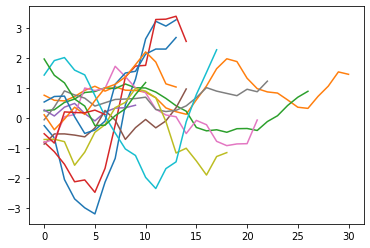

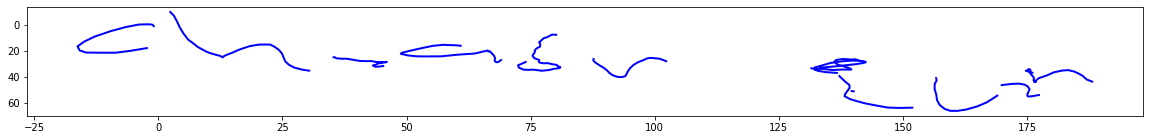

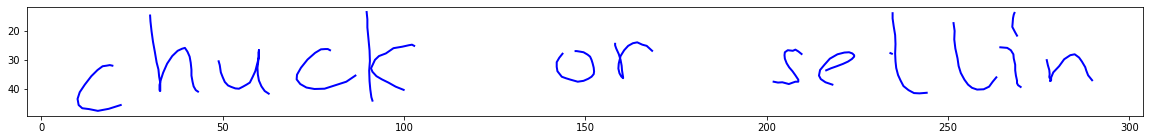

In [7]:
from scipy.fft import fft, ifft

base_file = "handwriting.p"
original_strokes, ascii = load_preprocessed(base_file)
index = 3843
tsteps = 300
data = original_strokes[index]
strokes = data[:tsteps] 

eos_preds = np.where(strokes[:,-1] == 1)
eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
modified_dx = np.zeros(strokes.shape[0])
modified_dy = np.zeros(strokes.shape[0])
for i in range(len(eos_preds)-1):
  start = eos_preds[i]+1
  stop = eos_preds[i+1]
  if stop - start <= 5:
    # do not modify the sequence that is too short
    modified_dx[start:stop] = strokes[start:stop, 0]
    modified_dy[start:stop] = strokes[start:stop, 1]
    continue
  dx = strokes[start+1:stop,0]
  dy = strokes[start+1:stop,1]

  fx = fft(dx)
  fy = fft(dy)
  # change the strength of distortion here
  strength = 0.7
  fx = fx * (1 + strength*np.random.randn(len(fx)))
  fy = fy * (1 + strength*np.random.randn(len(fy)))
  dx = np.real(ifft(fx))
  dy = np.real(ifft(fy))

  modified_dx[start] = strokes[start,0]
  modified_dy[start] = strokes[start,1]
  modified_dx[start+1:stop] = dx.copy()
  modified_dy[start+1:stop] = dy.copy()
  #beginnings.append((strokes[start,0], strokes[start,1]))
  plt.plot(dx)


modified_strokes = np.vstack([modified_dx, modified_dy, strokes[:,-1]]).T
modified_strokes[:,:-1] = np.cumsum(modified_strokes[:,:-1], axis=0)
line_plot(modified_strokes)

# draw original for comparison
strokes[:,:-1] = np.cumsum(strokes[:,:-1], axis=0)
line_plot(strokes)

# Create training and validation datasets

In [8]:
tsteps = 300
def create_damaged_data(base_file, start, end, filename):
  from scipy.fft import fft, ifft
  original_strokes, ascii = load_preprocessed(base_file)
  print(len(original_strokes))
  source = []
  target = []
  for i in range(start, end):
    data = original_strokes[i]
    strokes = data[:tsteps] 
    target.append(np.copy(strokes))

    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    modified_dx = np.zeros(strokes.shape[0])
    modified_dy = np.zeros(strokes.shape[0])
    for i in range(len(eos_preds)-1):
      start = eos_preds[i]+1
      stop = eos_preds[i+1]
      if stop - start <= 5:
        # do not modify the sequence that is too short
        modified_dx[start:stop] = strokes[start:stop, 0]
        modified_dy[start:stop] = strokes[start:stop, 1]
        continue
      dx = strokes[start+1:stop,0]
      dy = strokes[start+1:stop,1]

      fx = fft(dx)
      fy = fft(dy)
      # change the strength of distortion here
      strength = 0.7
      fx = fx * (1 + strength*np.random.randn(len(fx)))
      fy = fy * (1 + strength*np.random.randn(len(fy)))
      dx = np.real(ifft(fx))
      dy = np.real(ifft(fy))

      modified_dx[start] = strokes[start,0]
      modified_dy[start] = strokes[start,1]
      modified_dx[start+1:stop] = dx.copy()
      modified_dy[start+1:stop] = dy.copy()
  
    source.append(np.vstack([modified_dx, modified_dy, strokes[:,-1]]).T)
  np.save(filename + "_source", np.array(source))
  np.save(filename + "_target", np.array(target))

create_damaged_data("handwriting.p", 1, 10000, "training")
create_damaged_data("handwriting.p", 10001, 11600, "validation")

# for i in range(5):
#   r = target[i]
#   strokes = r.copy()
#   strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
#   line_plot(strokes)

11600
11600


In [ ]:
def draw_strokes(raw_data):
  strokes = raw_data.copy()
  strokes[:,:-1] = np.cumsum(raw_data[:,:-1], axis=0)
  line_plot(strokes)

# Create PyTorch dataset
source is the model input - 3 dimensional array: dx, dy, pen state

target is the ground truth output - 3 dimensional array: dx, dy, pen state

In [9]:
from torch.utils.data import Dataset, DataLoader
class IAMData(Dataset):
  def __init__(self, source, target):
    self.source = np.load(source).astype(np.float32)
    self.target = np.load(target).astype(np.float32)
  def __len__(self):
    return self.source.shape[0]
  def __getitem__(self,idx):
    return self.source[idx], self.target[idx]

# Training
It's recommended that decoder has more hidden units than encoder

In [10]:

from data_utils import *
from helpers import *
from dataset import *
from StyleTransferNoLabel import *
from UnconditionalDecoder import *
from HyperParams import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# parameters
num_input_features = 3
num_output_features = 3
encoder_hidden_size = 180
decoder_hidden_size = 360
seq_length = 300
learning_rate = 0.001
min_lr = 0.0001
lr_decay = 0.995
num_epochs = 250
grad_clip = 1.0


In [11]:
from torch import nn
import torch
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

def init_network(m):
  if isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)

def decay(optimizer):
  """Decay learning rate by a factor of lr_decay"""
  for param_group in optimizer.param_groups:
    if param_group['lr']>min_lr:
      param_group['lr'] *= lr_decay
  return optimizer
# a simple autoencoder model
class Encoder(nn.Module):
  def __init__(self, seq_len, num_features, hidden_size):
    super().__init__()
    
    self.seq_len = seq_len
    self.num_features = num_features
    self.hidden_size = hidden_size
    self.hidden_cell_size = (2 * hidden_size)
    self.LSTM = nn.LSTM(
        input_size = num_features,
        hidden_size = hidden_size,
        num_layers = 1,
        batch_first=True
    )
    self.relu = nn.ReLU()

    init_network(self.LSTM)
      
  def forward(self, x): # x is N,L,C
    # Inputs: input, (h_0, c_0). -> If (h_0, c_0) is not provided, both h_0 and c_0 default to zero.
    x, (hidden, cell) = self.LSTM(x)  
    final_hidden = hidden[-1,:,:]
    return self.relu(final_hidden) # embedded shape (batch, hidden_size)

class Decoder(nn.Module):
  def __init__(self, seq_len, input_size, hidden_size, output_size):
    super().__init__()

    self.seq_len = seq_len
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.LSTM = nn.LSTM(
        input_size = input_size,
        hidden_size = self.hidden_size,
        batch_first=True
    )

    self.relu = nn.ReLU()
    
    self.fc1 = nn.Linear(self.hidden_size, self.hidden_size // 4)
    self.fc2 = nn.Linear(self.hidden_size // 4, output_size)

    init_network(self.LSTM)
    init_network(self.fc1)
    init_network(self.fc2)
      
  def forward(self, last_hidden, inputs):
    # x is N,C (C is encoder hidden_size)
    # after repeat, LSTM input is N,L,C
    last_hidden = last_hidden.unsqueeze(1).repeat(1, self.seq_len, 1)
    x = torch.cat([last_hidden, inputs], dim=2)
    x, (hidden_state, cell_state) = self.LSTM(x) 
    # output sequence is N,L,C (C is decoder hidden_size)
    x = x.reshape((-1, self.seq_len, self.hidden_size))
    y = self.fc1(x) # becomes N,L,C2 (C2 is output_size)

    out = self.fc2(self.relu(y))
    out[:,:,2] = torch.sigmoid(out[:,:,2])
    return out

class LSTMAutoEncoder(nn.Module):
  def __init__(self, num_input_features, num_output_features, encoder_hidden_size, decoder_hidden_size, seq_len):
    super().__init__()
    self.encoder = Encoder(seq_len, num_input_features, encoder_hidden_size).cuda()
    self.decoder = Decoder(seq_len, encoder_hidden_size + num_input_features, decoder_hidden_size, num_output_features).cuda()
    self.seq_len = seq_len
    self.mse_loss = nn.MSELoss()
    self.scale_data = 2
    self.training_loss_history = []
    self.validation_loss_history = []

  def loss(self, computed, real):
    batch_size = computed.size(0)
    l1 = self.mse_loss(computed[:,:,:2], real[:,:,:2]) * self.scale_data
    real_eos = real[:,:,2]
    computed_eos = torch.clamp(computed[:,:,2], 0.0, 1.0)
    l2 = -torch.log(computed_eos+1e-10) * real[:,:,2] - torch.log(1.0 - computed_eos+1e-10) * (1.0 - real_eos)
    return l1 + torch.sum(l2) / self.seq_len / batch_size

  def forward(self, inputs): # inputs is N,C,L, C=2
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded, inputs)
    return decoded

  def fit(self, training_loader, validation_loader=None): 
    self.training_loader = training_loader
    self.validation_loader = validation_loader
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
      self.train()
      training_loss = 0.0
      for i,data in enumerate(training_loader):
        optimizer.zero_grad()

        inputs = Variable(data[0]).cuda()
        target = Variable(data[1]).cuda()

        batch_size = inputs.size(0)
        outputs = self(inputs) # forward

        loss = self.loss(outputs, target)

        loss.backward()
        nn.utils.clip_grad_norm_(self.parameters(), grad_clip)
        optimizer.step()

        training_loss += loss.item()
      
      if epoch % 10 == 0:
        # run validation dataset
        validation_loss = self.validation()
        print(f"epoch: {epoch}, training loss: {training_loss}, validation loss: {validation_loss}")
        self.validation_loss_history.append((epoch, validation_loss))

      self.training_loss_history.append((epoch, training_loss))

      decay(optimizer)

  def generate(self, x):
    self.eval()
    return self(x)

  def validation(self):
    if not self.validation_loader:
      return 0.0
    self.eval()
    validation_loss = 0.0
    for i,data in enumerate(self.validation_loader):

      inputs = Variable(data[0]).cuda()
      target = Variable(data[1]).cuda()
      batch_size = inputs.size(0)

      outputs = self(inputs)

      loss = self.loss(outputs, target)
      validation_loss += loss.item()
    return validation_loss

  def save(self, name):
    torch.save(self.encoder.state_dict(), name+"_encoder.pth")
    torch.save(self.decoder.state_dict(), name+"_decoder.pth")

  def load(self, encoder_path, decoder_path):
    saved_encoder = torch.load(encoder_path)
    saved_decoder = torch.load(decoder_path)
    self.encoder.load_state_dict(saved_encoder)
    self.decoder.load_state_dict(saved_decoder)



In [12]:
model = LSTMAutoEncoder(num_input_features, num_output_features, encoder_hidden_size, decoder_hidden_size, seq_length)

training_dataset = IAMData('training_source.npy','training_target.npy')
training_dataloader = DataLoader(training_dataset, batch_size=20, shuffle=True, num_workers=0)
validation_dataset = IAMData('validation_source.npy','validation_target.npy')
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True, num_workers=0)


# Execute training


In [ ]:
model.fit(training_dataloader, validation_dataloader)
model.save("01")

# Load existing model

In [13]:
model.load("../models/handwriting_encoder_01.pth", "../models/handwriting_decoder_01.pth")

torch.Size([1, 300, 3])
torch.Size([1, 300, 3])


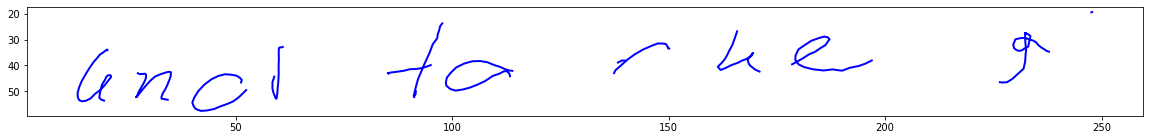

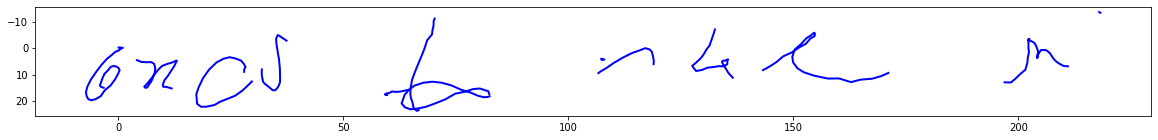

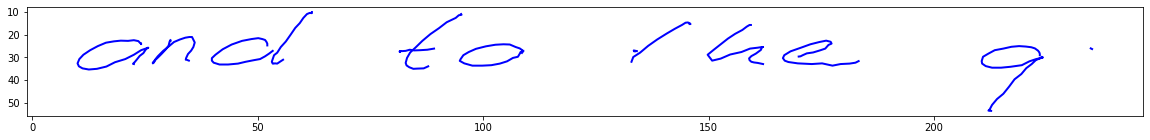

In [15]:
# test model performance with training set

index = 665

inputs = torch.FloatTensor(training_dataset[index][0]).cuda().unsqueeze(0)
print(inputs.size())
outputs = model.generate(inputs)
print(outputs.size())

inputs = inputs.squeeze().detach().cpu().numpy()
outputs = outputs.squeeze().detach().cpu().numpy()

# model output
strokes = outputs.copy()
strokes[:,:-1] = np.cumsum(outputs[:,:-1], axis=0)
strokes[:,2][np.where(strokes[:,2] < 0.5)] = 0
strokes[:,2][np.where(strokes[:,2] > 0.5)] = 1
line_plot(strokes)

# model input
original = training_dataset[index][0]
strokes = original.copy()
strokes[:,:-1] = np.cumsum(original[:,:-1], axis=0)
line_plot(strokes)

# ground truth
truth = training_dataset[index][1]
strokes = truth.copy()
strokes[:,:-1] = np.cumsum(truth[:,:-1], axis=0)
line_plot(strokes)

torch.Size([1, 300, 3])
torch.Size([1, 300, 3])


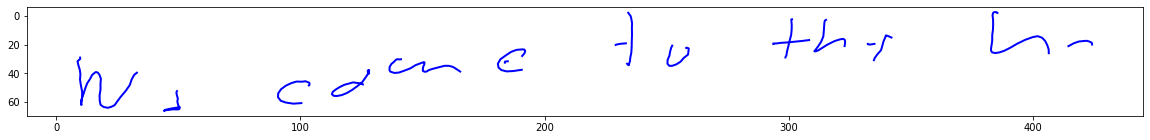

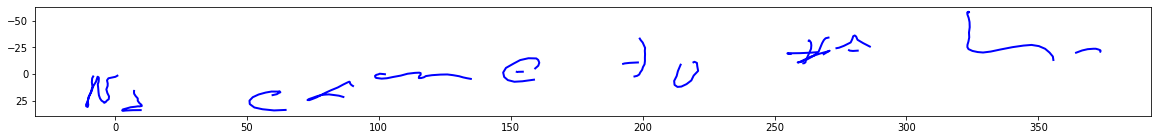

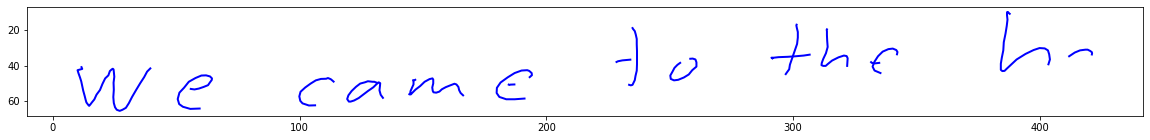

In [22]:
# validation
index = 99

inputs = torch.FloatTensor(validation_dataset[index][0]).cuda().unsqueeze(0)
print(inputs.size())
outputs = model.generate(inputs)
print(outputs.size())

inputs = inputs.squeeze().detach().cpu().numpy()
outputs = outputs.squeeze().detach().cpu().numpy()

strokes = outputs.copy()
strokes[:,:-1] = np.cumsum(outputs[:,:-1], axis=0)
strokes[:,2][np.where(strokes[:,2] < 0.5)] = 0
strokes[:,2][np.where(strokes[:,2] > 0.5)] = 1
line_plot(strokes)

original = validation_dataset[index][0]
strokes = original.copy()
strokes[:,:-1] = np.cumsum(original[:,:-1], axis=0)
line_plot(strokes)
truth = validation_dataset[index][1]
strokes = truth.copy()
strokes[:,:-1] = np.cumsum(truth[:,:-1], axis=0)
line_plot(strokes)

In [ ]:
%cd "/content/drive/My Drive/draw_ai_applications/handwriting-synthesis-new"
# second experiment - down-sample the stroke points
from scipy.fft import fft, ifft

style_id = 6
strokes = np.load("styles/style-{}-strokes.npy".format(style_id))

eos_preds = np.where(strokes[:,-1] == 1)
eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
modified_dx = np.zeros(strokes.shape[0])
modified_dy = np.zeros(strokes.shape[0])
for k in range(len(eos_preds)-1):
  start = eos_preds[k]+1
  stop = eos_preds[k+1]
  if stop - start <= 5:
    # do not modify the sequence that is too short
    continue

  dx = strokes[start+1:stop,0]
  dy = strokes[start+1:stop,1]
  print(stop - start)

  i = 0
  n = len(dx)
  while i < n:
    begin = i
    num_skip = np.random.randint(7,15)
    end = i+num_skip
    if end >= n:
      break
    move_x = dx[end]-dx[begin]
    move_y = dy[end]-dy[begin]
    j = i+1
    while j < end:
      dx[j] = dx[i]+move_x*(j-i)/num_skip
      dy[j] = dy[i]+move_y*(j-i)/num_skip
      j += 1

    i = end+1
    
  modified_dx[start] = strokes[start,0]
  modified_dy[start] = strokes[start,1]
  modified_dx[start+1:stop] = dx.copy()
  modified_dy[start+1:stop] = dy.copy()

modified_strokes = np.vstack([modified_dx, modified_dy, strokes[:,-1]]).T
modified_strokes[:,:-1] = np.cumsum(modified_strokes[:,:-1], axis=0)
line_plot(modified_strokes, False)

[Errno 2] No such file or directory: '/content/drive/My Drive/draw_ai_applications/handwriting-synthesis-new'
/content


NameError: ignored